In [2]:
import numpy as np
import anndata as ann
import pandas as pd
import scanpy as sc
import scvelo as scv
import scipy as sp
# import scipy as sci
import matplotlib.pyplot as pl
import matplotlib.pylab as pit
# import math
# import csv
# import loompy
import leidenalg
import bbknn
#pretty plotting
import seaborn as sb
import scrublet as scr

from IPython.core.display import display, HTML
from matplotlib import rcParams

In [4]:
adata=sc.read('/Users/Chiara/Documents/PhD/Project_primary_resistance/scRNAseq/10x_5_treatment_data_v3/Fibroblasts/data/Overlay_treatment_preprocessing_fibroblasts_8661_fibro_bbknn_V01-sb.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 345 × 5859
    obs: 'batch', 'batch_key', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'phase', 'S_score', 'G2M_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log_total_counts', 'log_pct_counts_ribo', 'log_pct_counts_mito', 'samples2', 'leiden', 'samples', 'umap_density_samples2', 'umap_density_samples'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_count

In [8]:
sc.settings.set_figure_params(dpi=120, dpi_save=300, vector_friendly=True, transparent=True, color_map='viridis')

In [9]:
Tab20c_2=[[0.19215686, 0.50980392, 0.74117647, 1.],
[0.61960784, 0.79215686, 0.88235294, 1.],
[0.90196078, 0.33333333, 0.05098039, 1.],
[0.45490196, 0.76862745, 0.4627451,  1.],
[0.19215686, 0.63921569, 0.32941176, 1.],
[0.45882353, 0.41960784, 0.69411765, 1.],
[0.61960784, 0.60392157, 0.78431373, 1.],  
[0.99215686, 0.68235294, 0.41960784, 1.],
[0.89019608, 0.46666667, 0.76078431, 1.]]

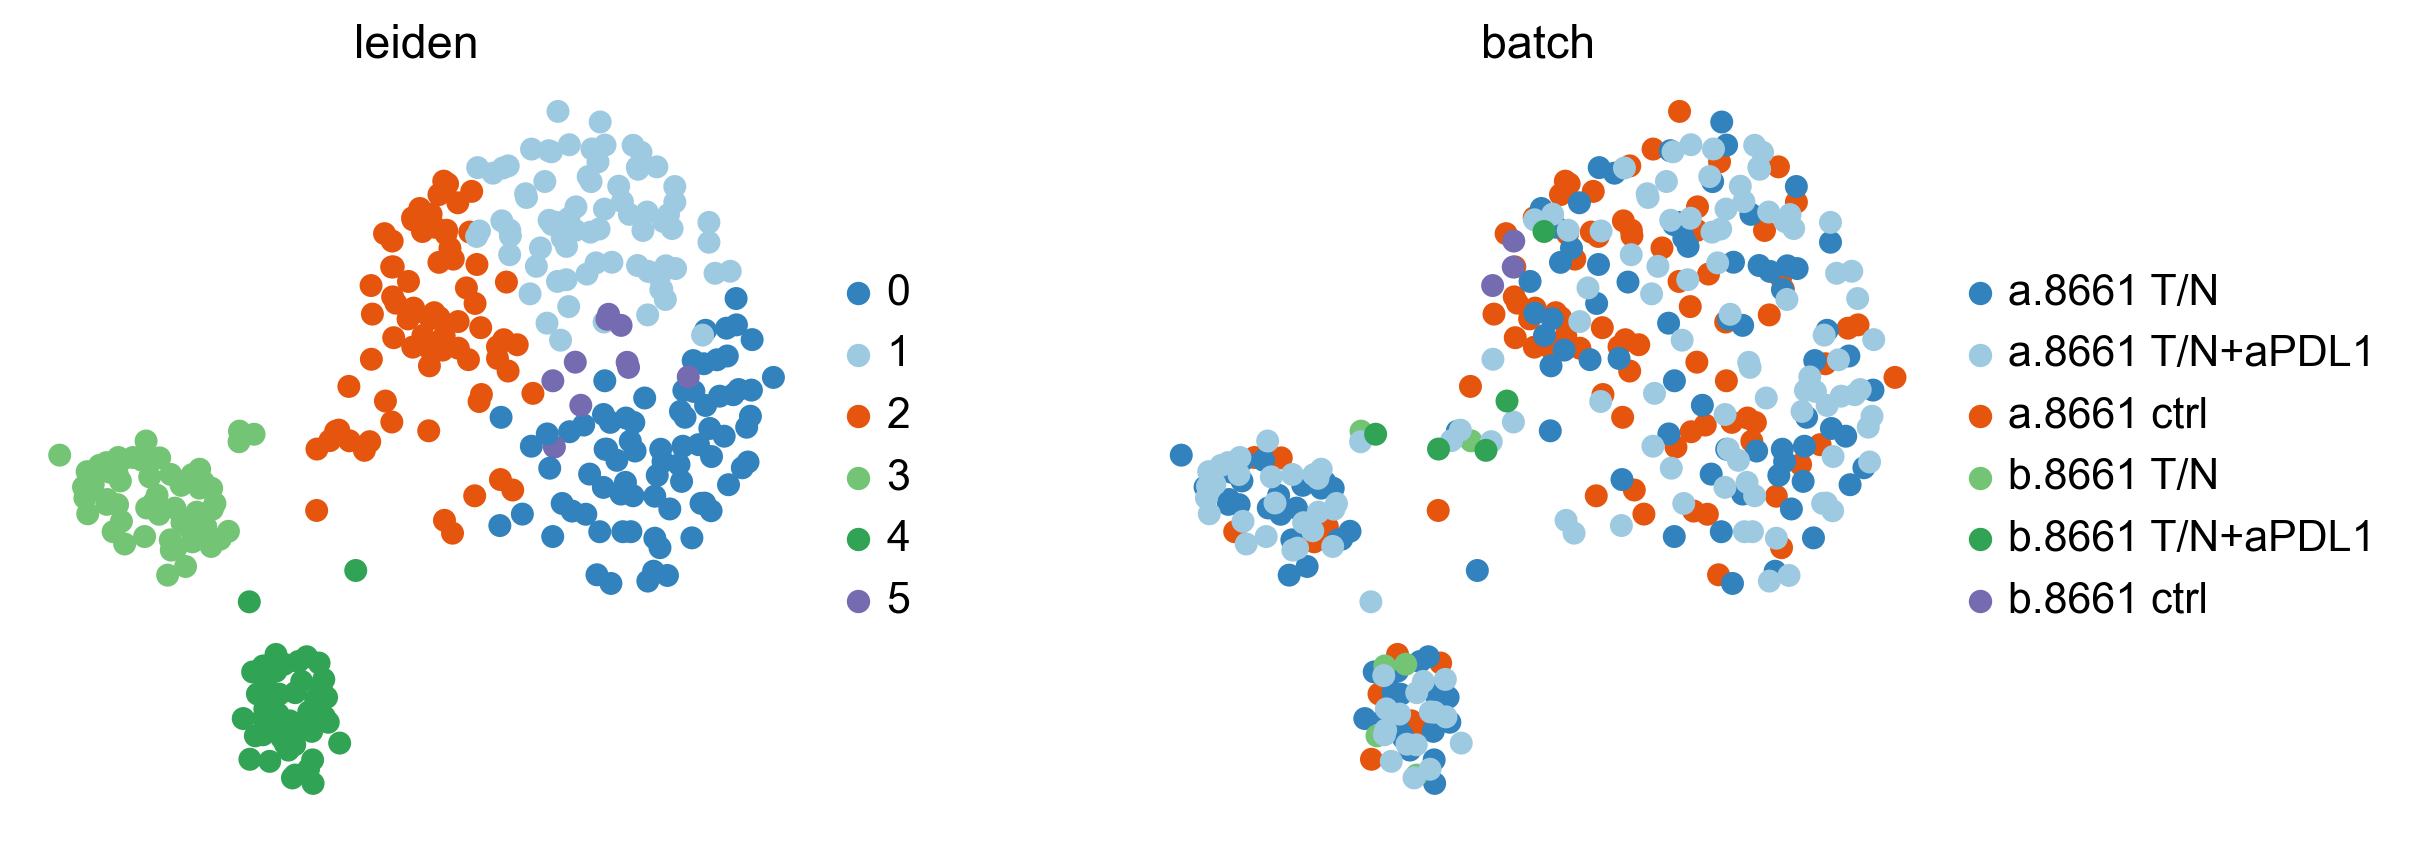

In [12]:
sc.pl.umap(adata, color=['leiden','batch'], wspace=0.3,frameon=False, palette=Tab20c_2,size=190)  



### Characterization of the clusters

Pan-fibroblast markers

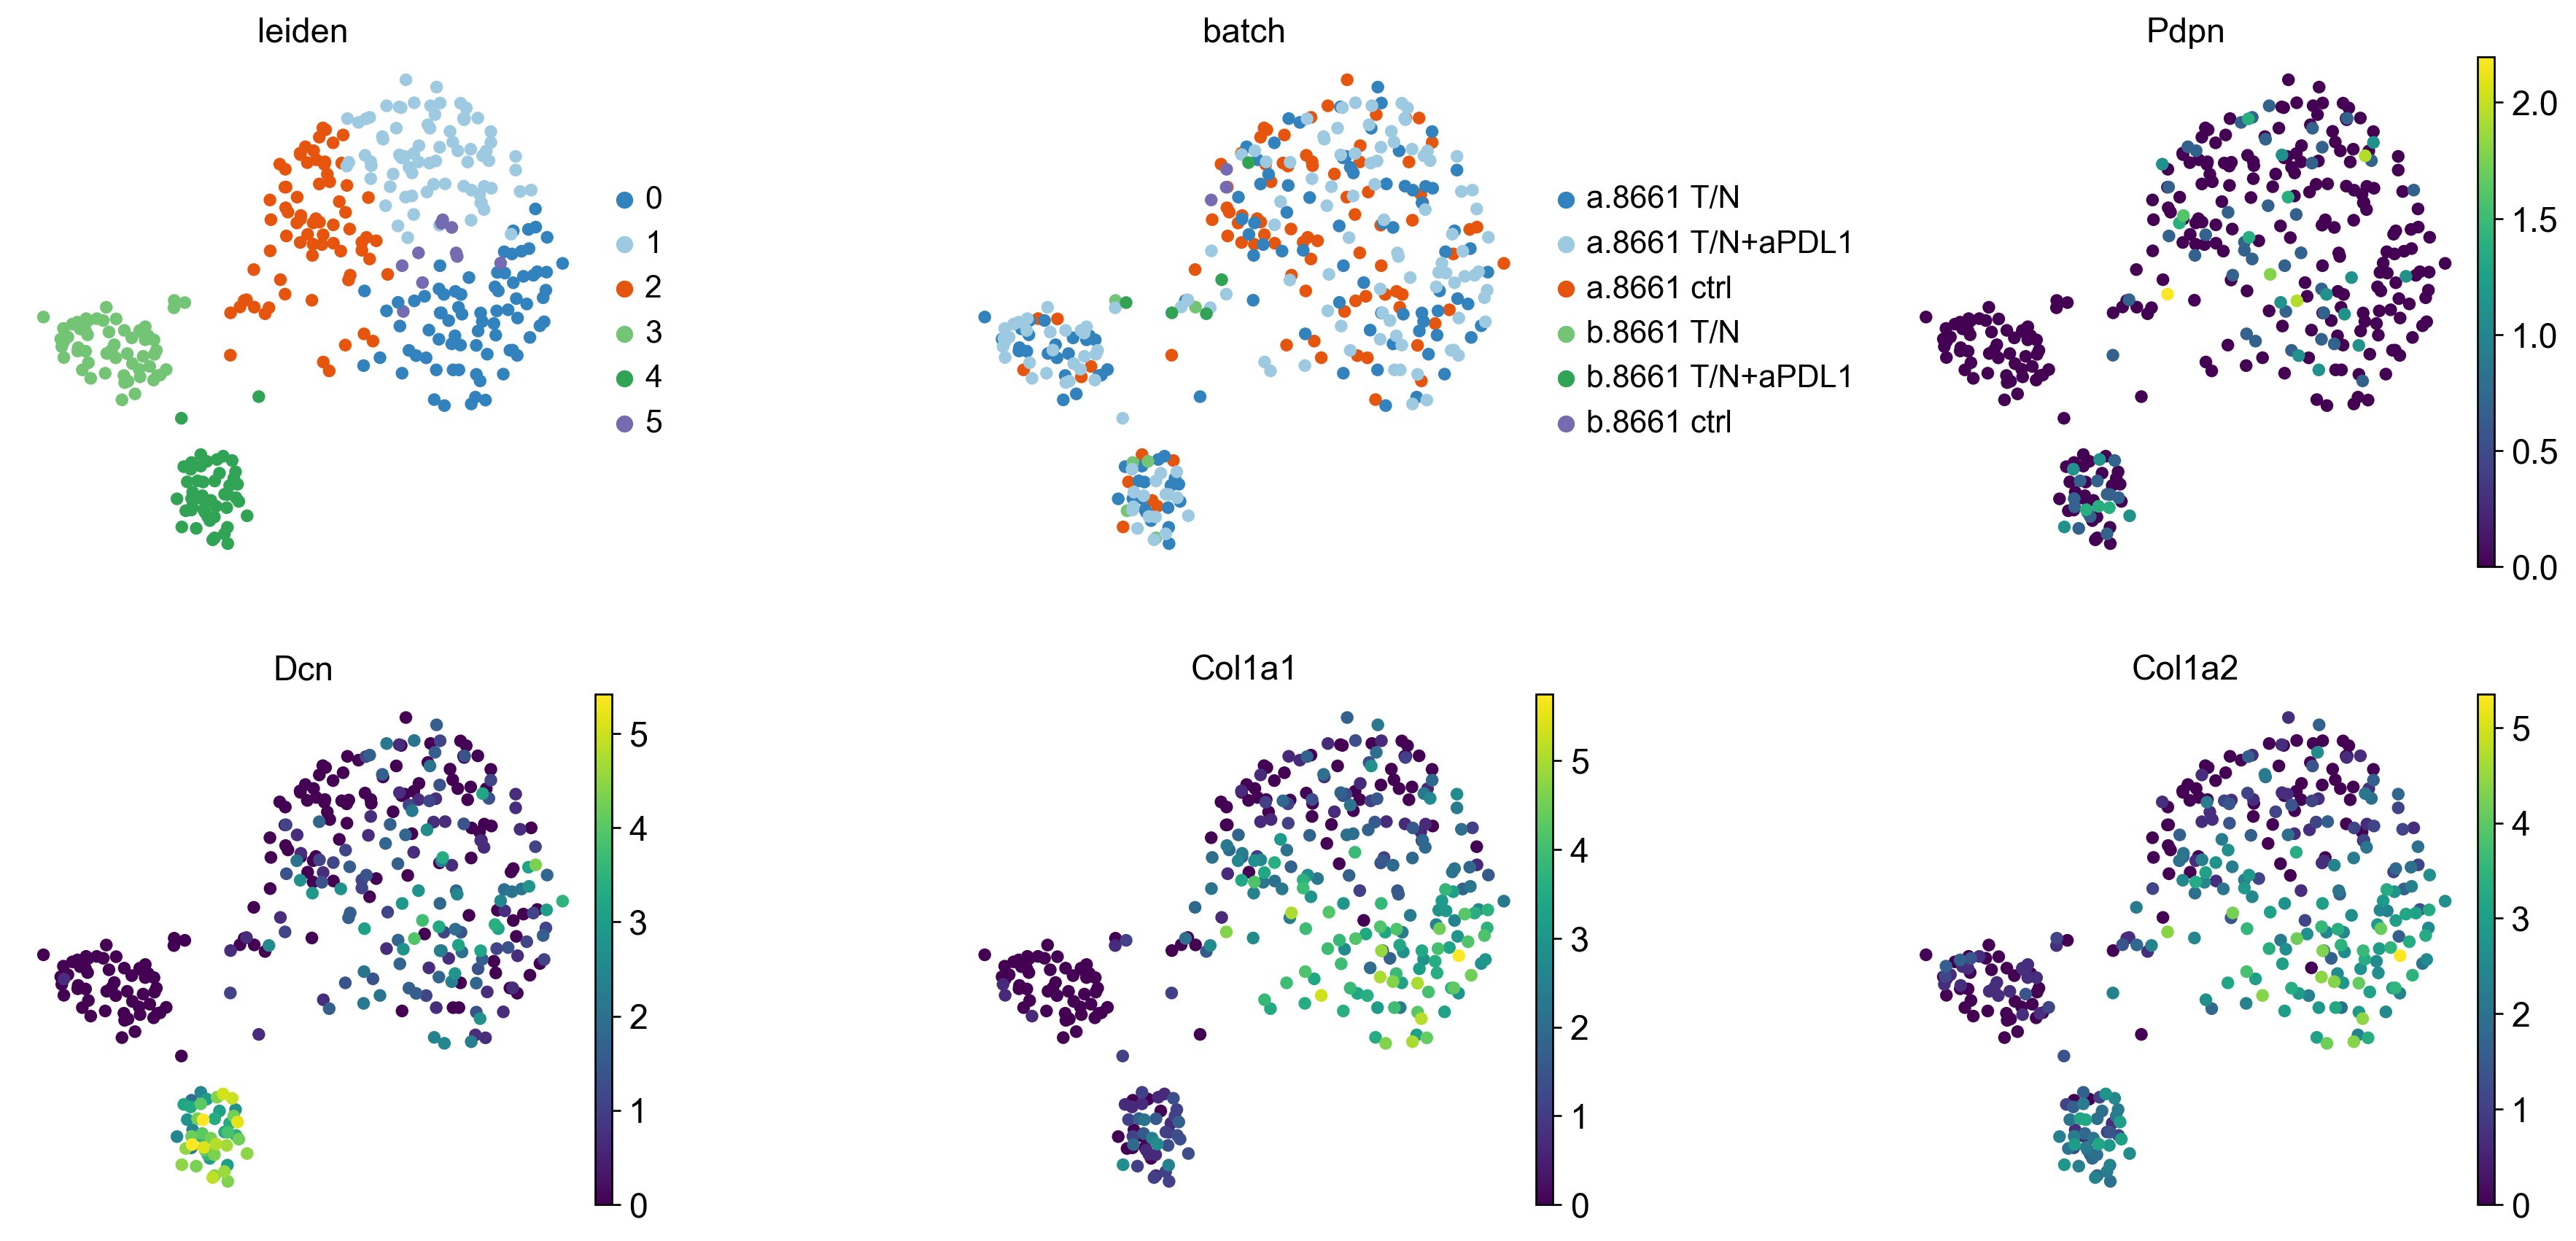

In [20]:
sc.pl.umap(adata, color=['leiden','batch','Pdpn', 'Dcn','Col1a1','Col1a2'],size=110, ncols=3, wspace=0.5,save='',frameon=False)

iCAF markers

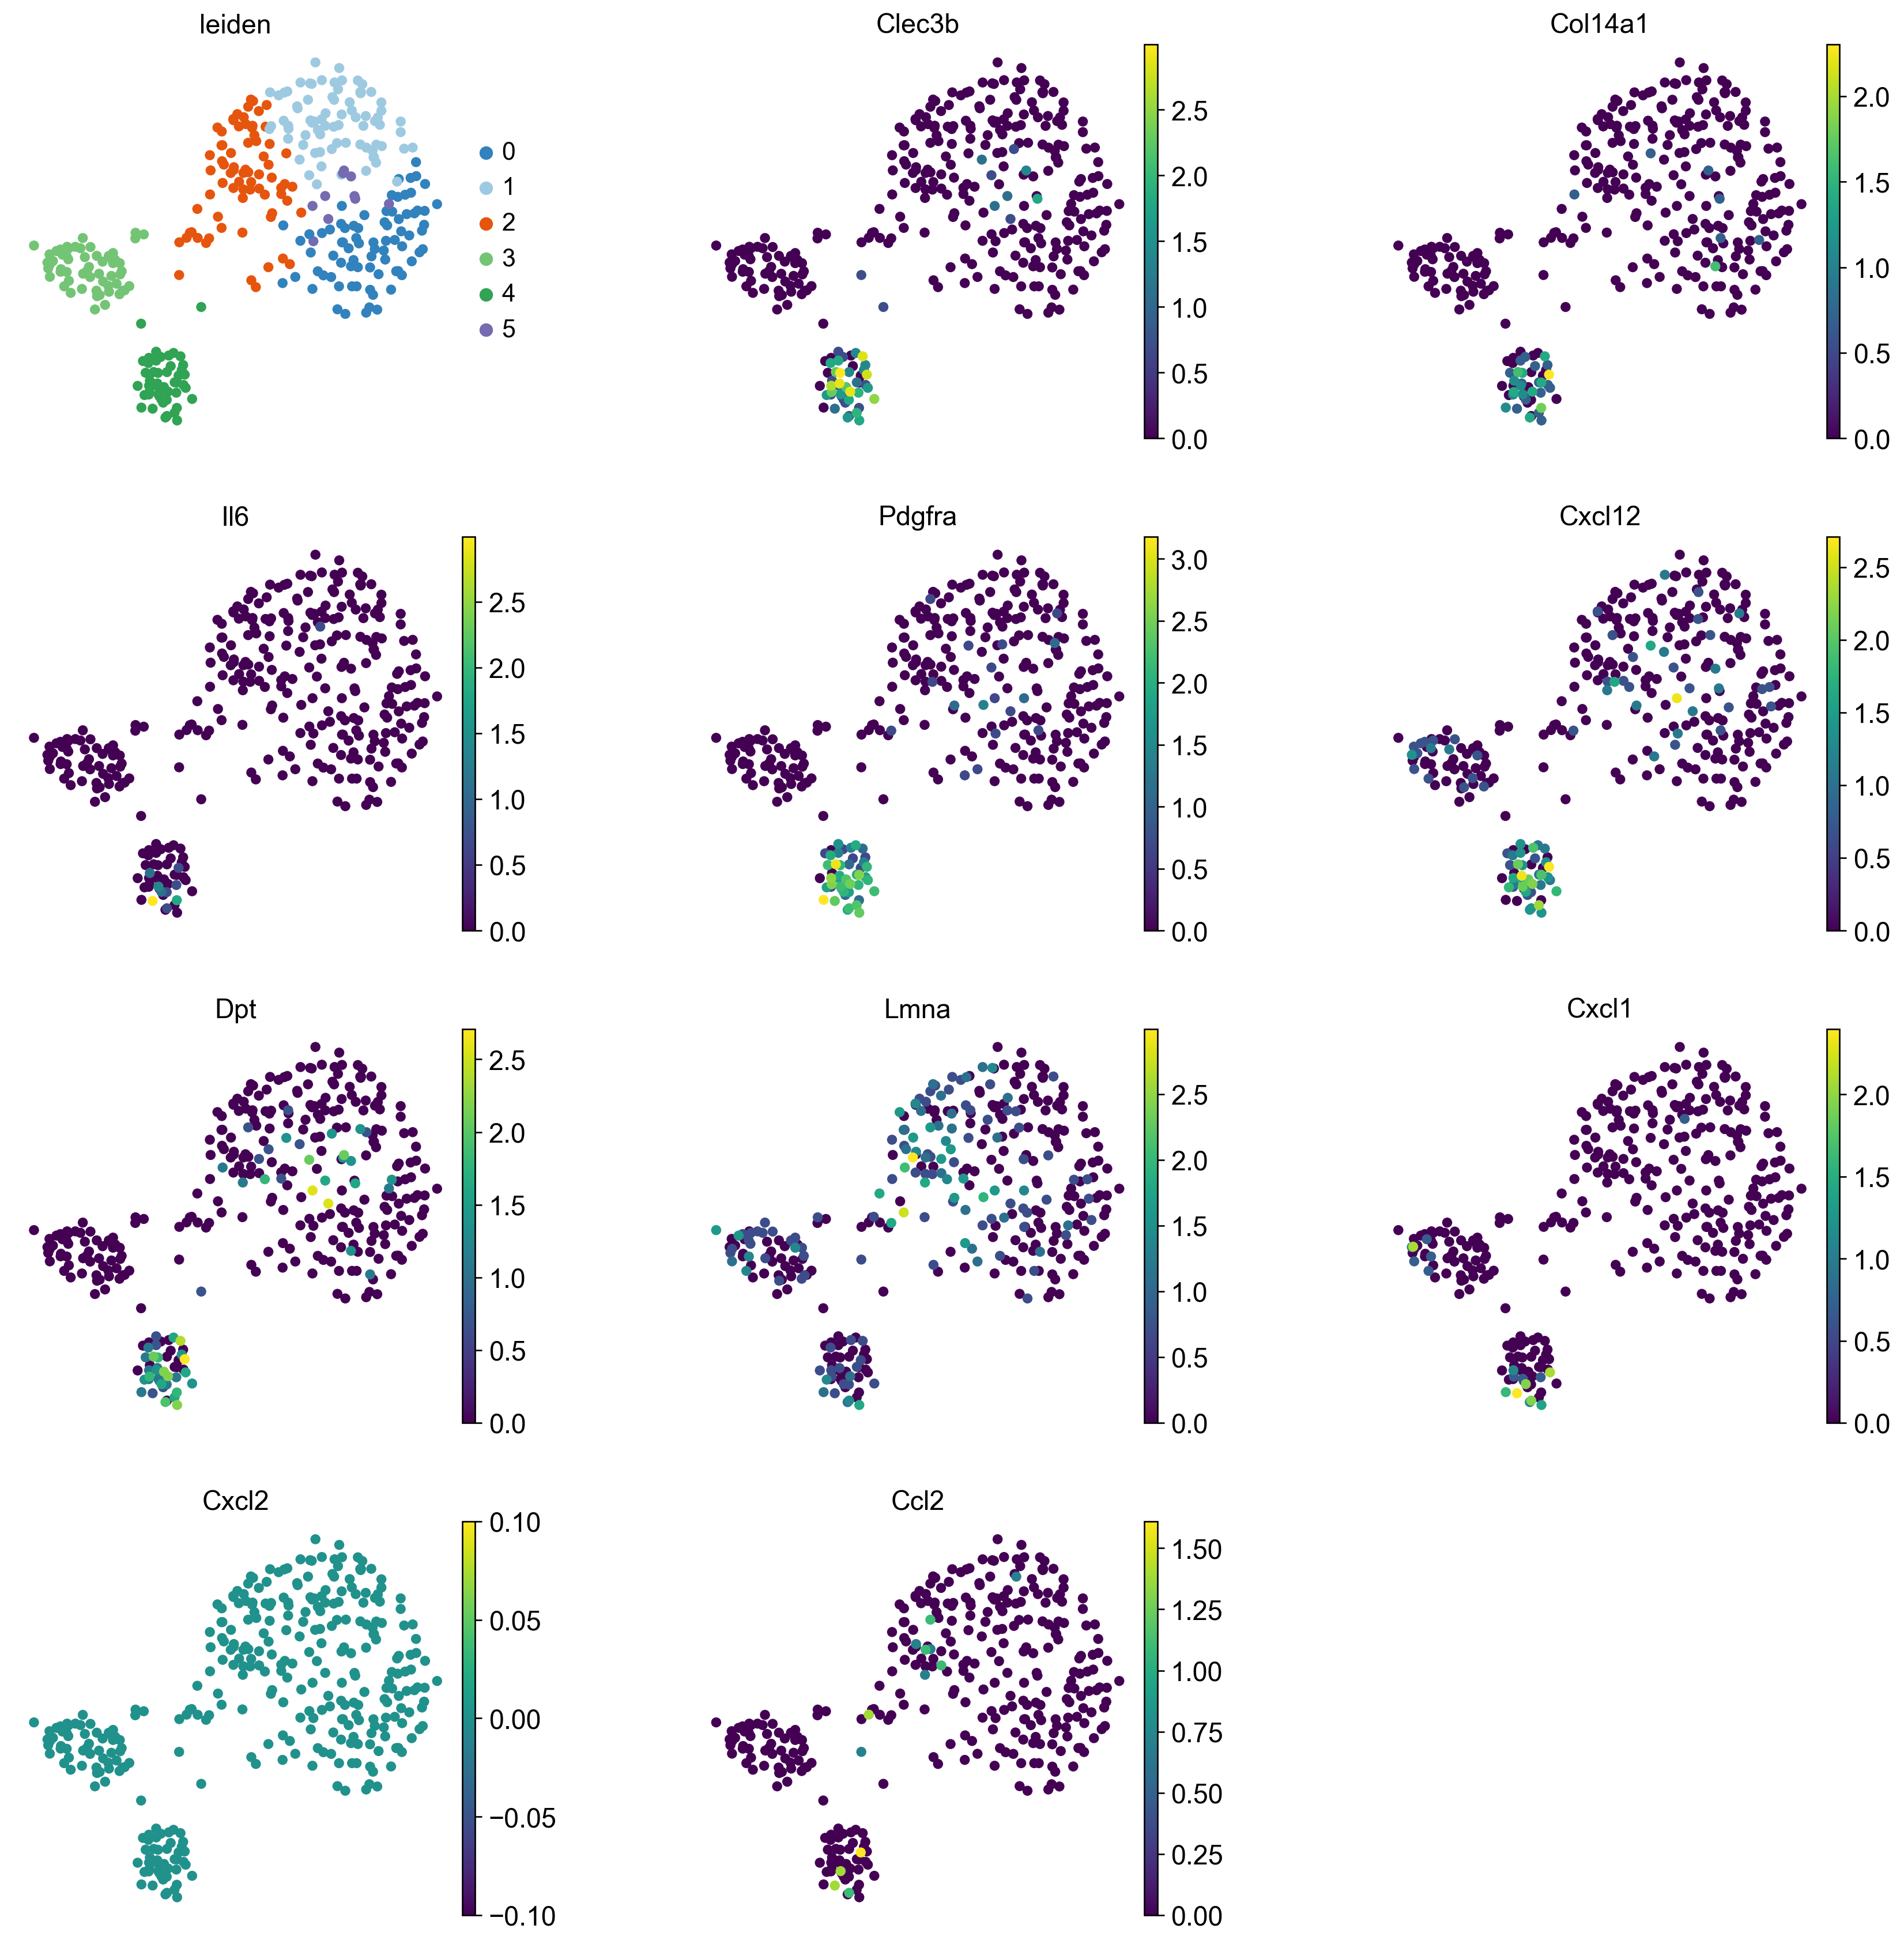

In [21]:
sc.pl.umap(adata, color=['leiden','Clec3b','Col14a1','Il6','Pdgfra','Cxcl12','Dpt','Lmna','Cxcl1','Cxcl2','Ccl2'],frameon=False, size=110,ncols=3, wspace=0.4,save='_iCAFs')

myCAF markers

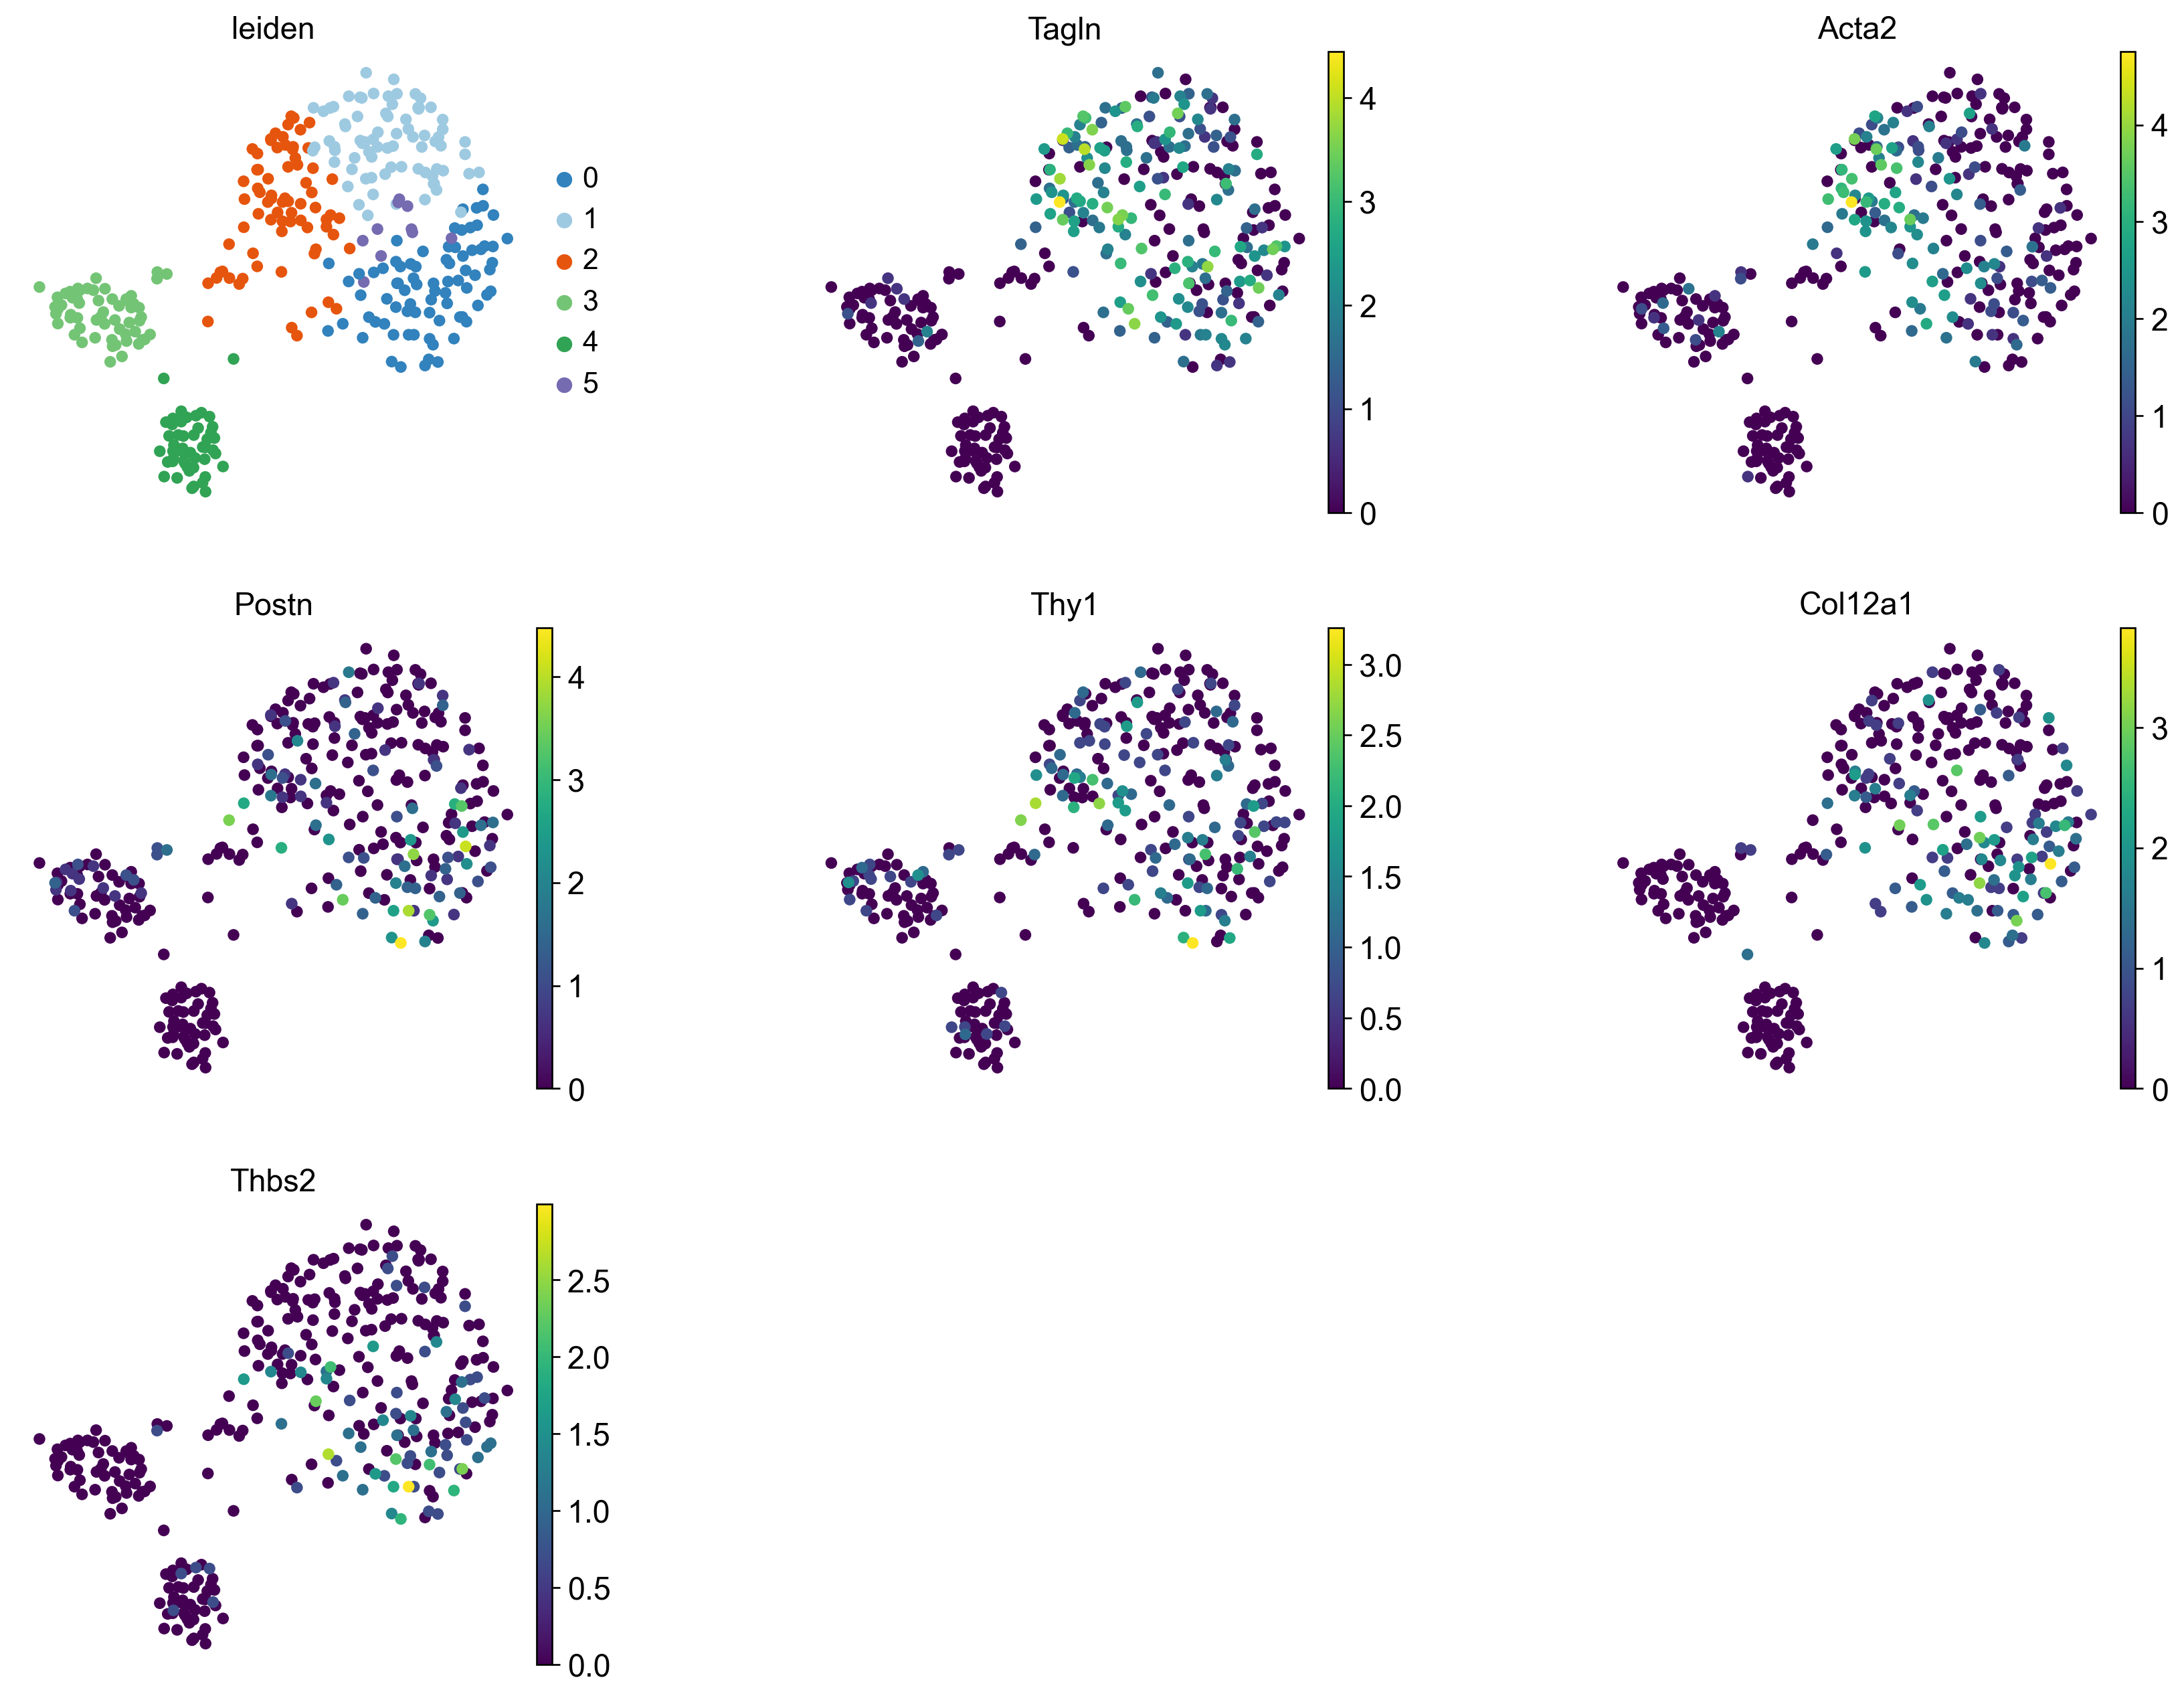

In [22]:
sc.pl.umap(adata, color=['leiden','Tagln', 'Acta2','Postn','Thy1','Col12a1','Thbs2'],frameon=False,size=110,ncols=3, wspace=0.4)

apCAF markers

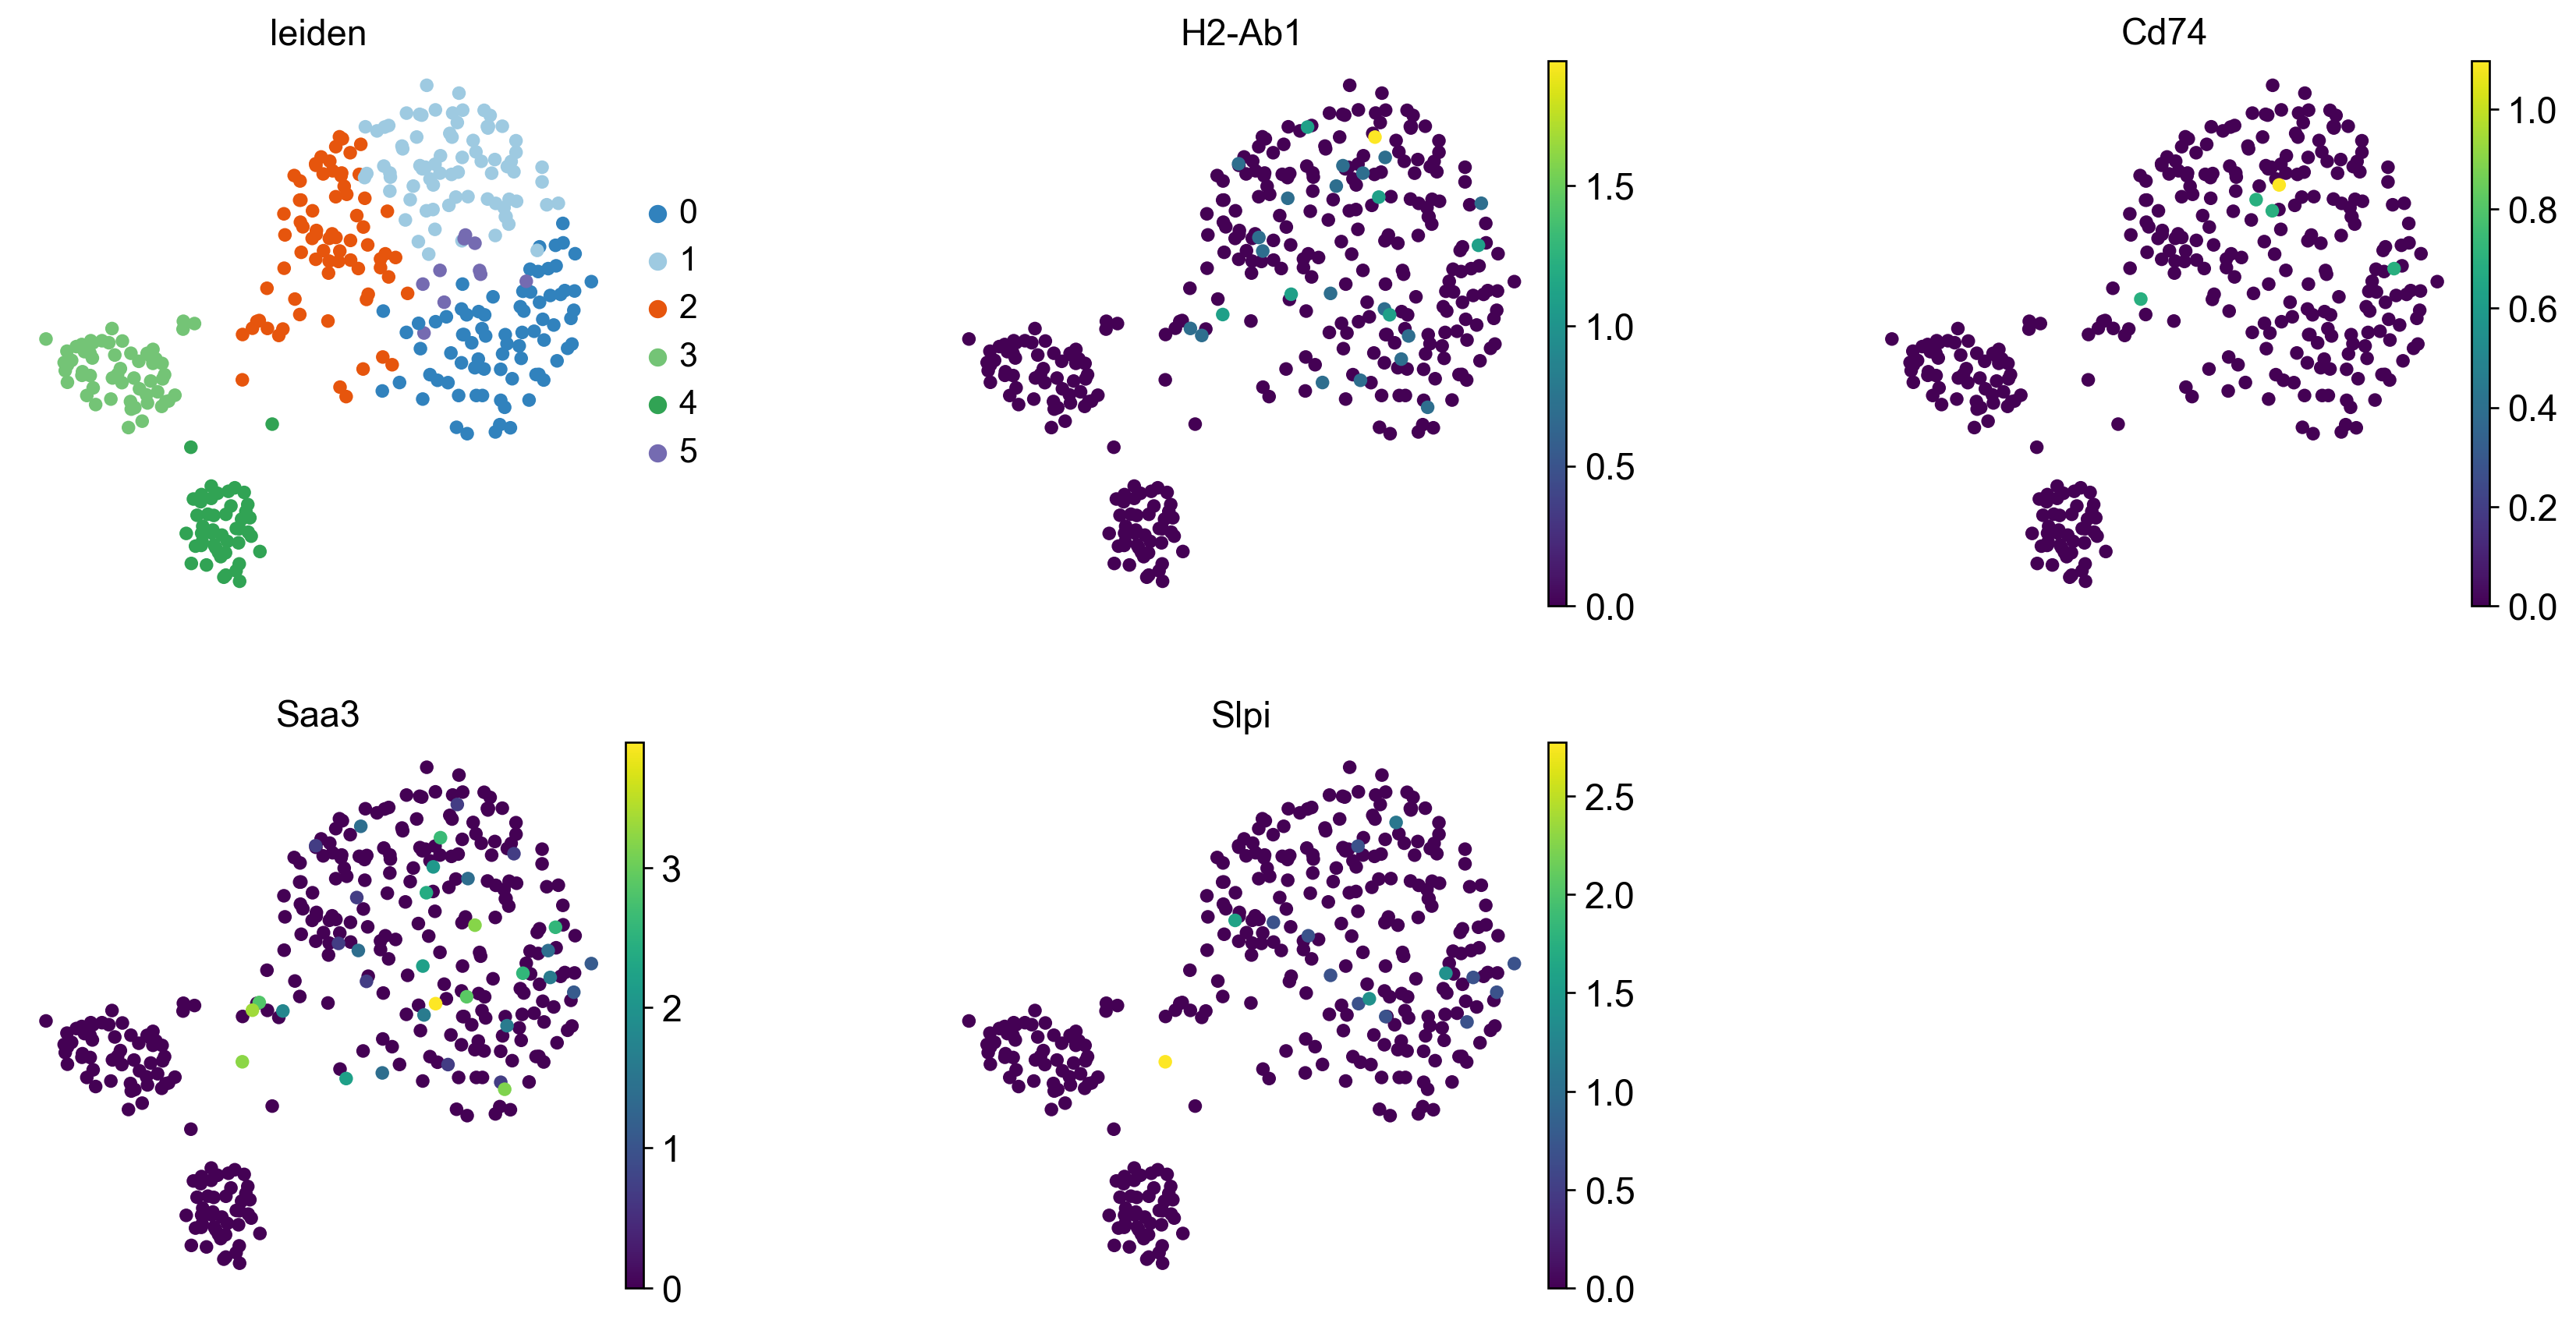

In [23]:
sc.pl.umap(adata, color=['leiden','H2-Ab1','Cd74','Saa3','Slpi'],size=110,ncols=3,frameon=False, wspace=0.4)

Lipofibroblasts

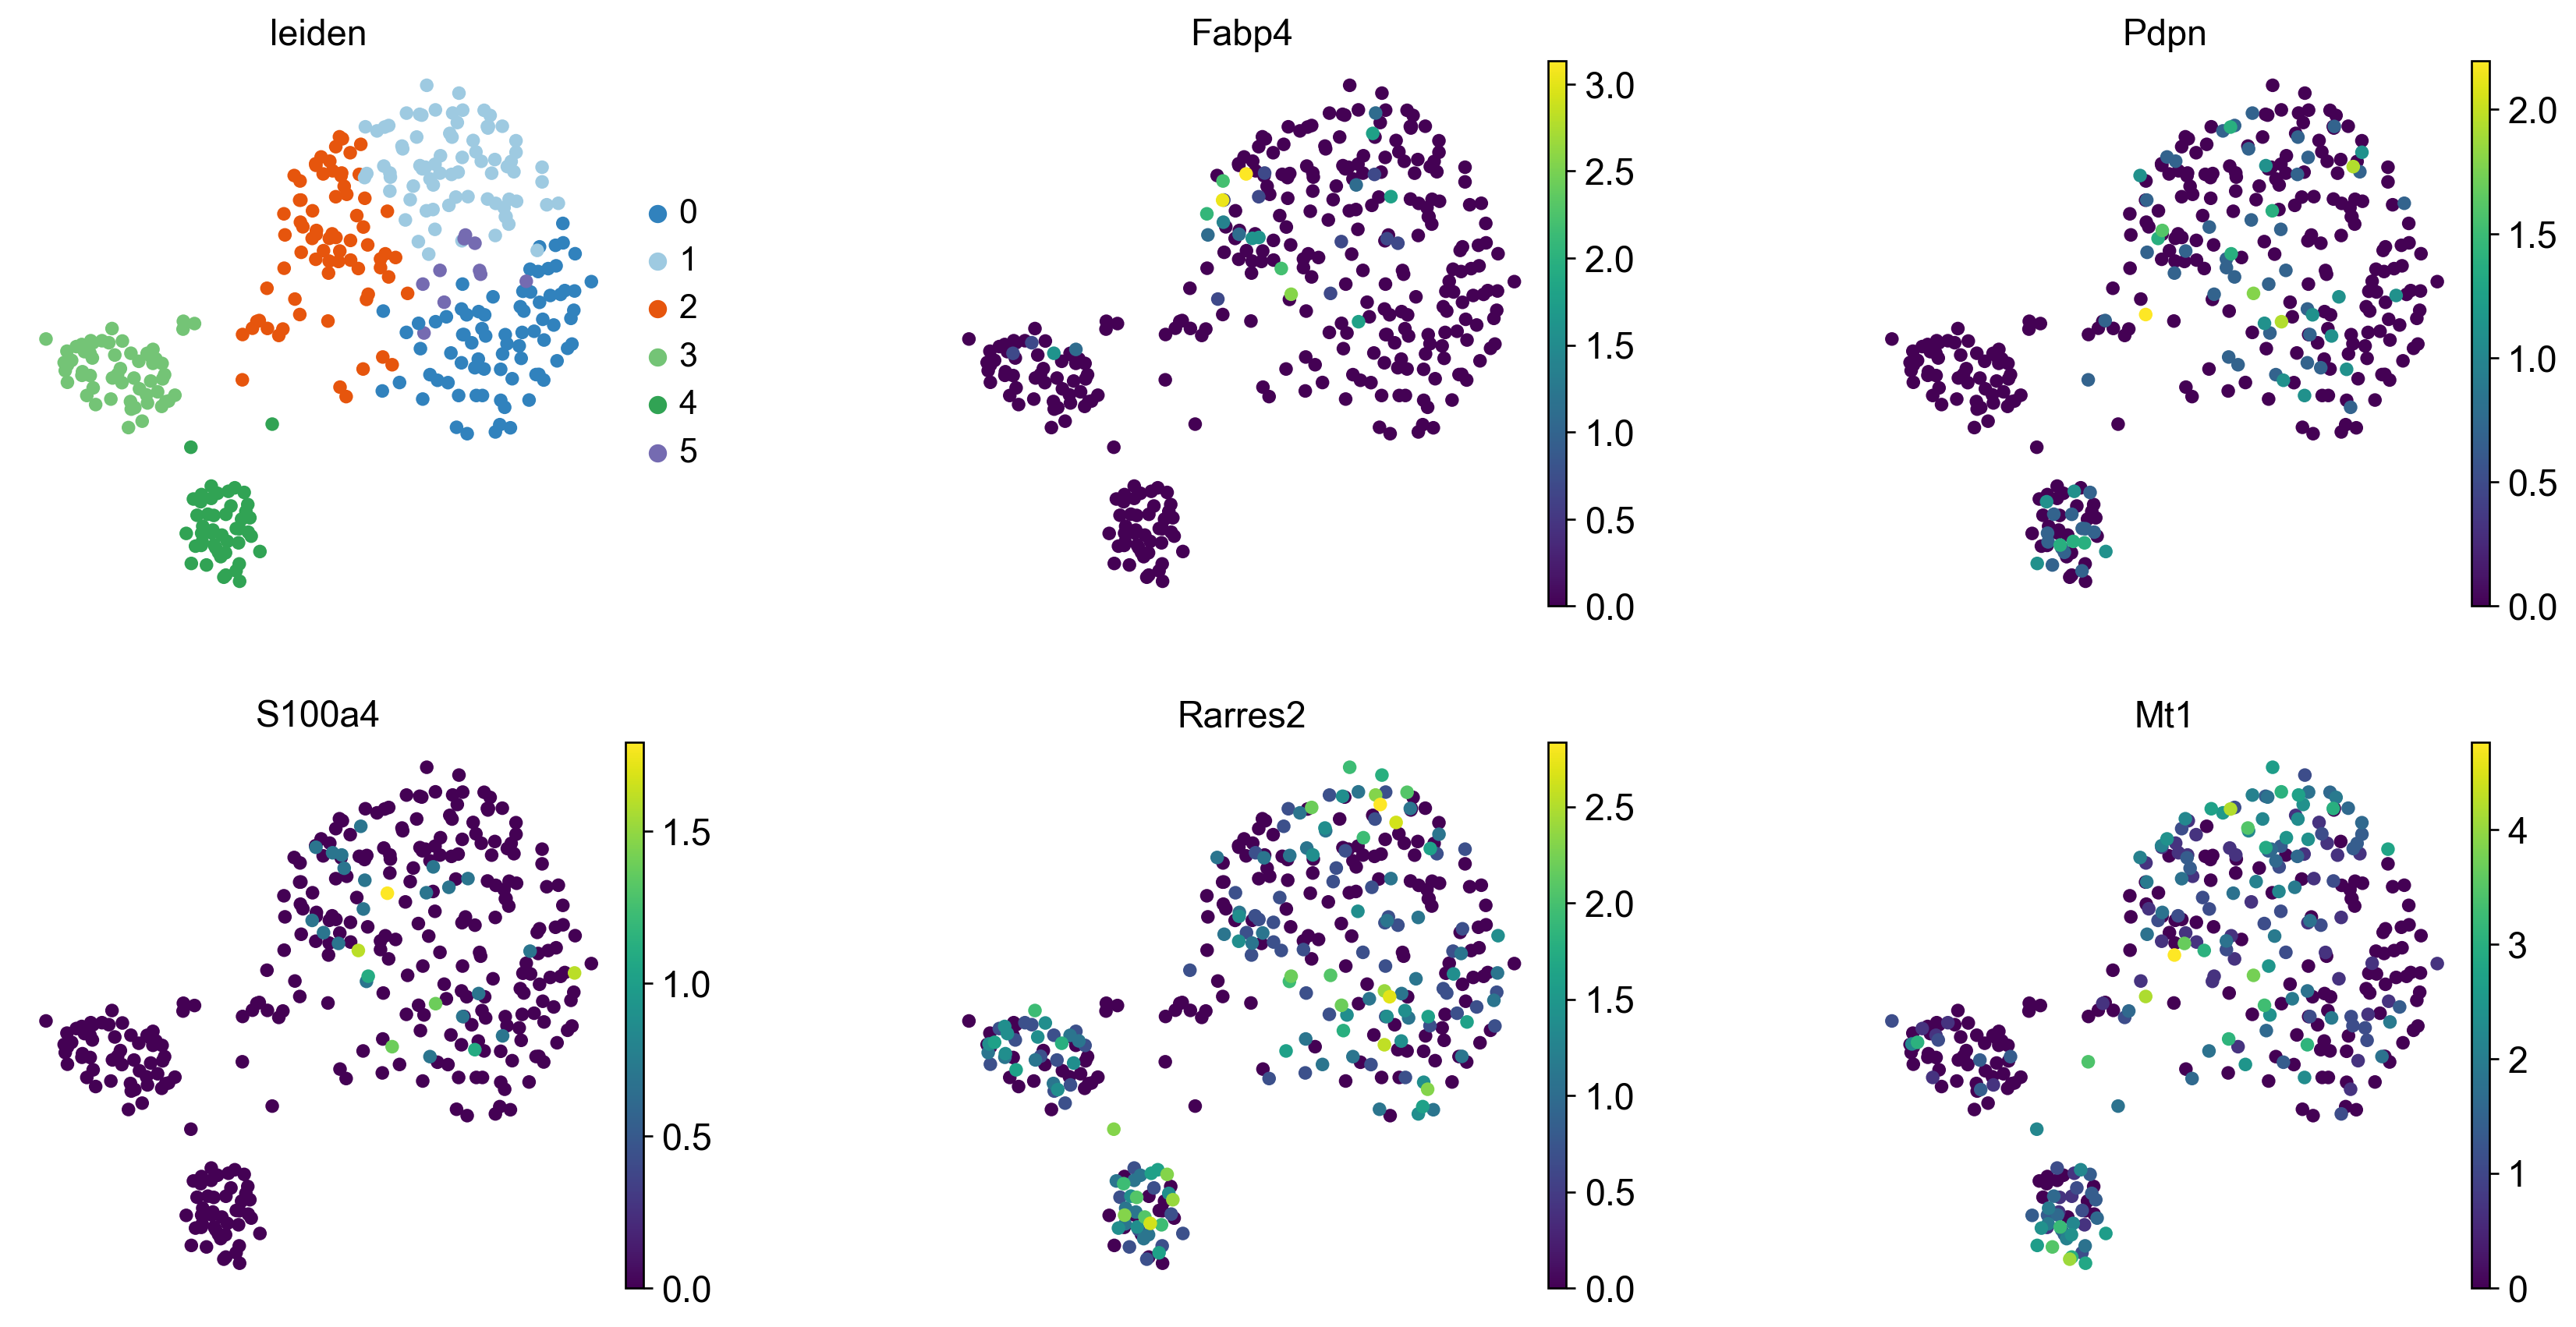

In [24]:
sc.pl.umap(adata, color=['leiden','Fabp4','Pdpn','S100a4','Rarres2','Mt1'],size=110,ncols=3,frameon=False, wspace=0.4)

### Cluster annotation

In [27]:
adata.obs['annotated'] = adata.obs['leiden'].cat.add_categories(['myoCAFs',
                                                                 'iCAFs'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0','1','2','5'])] = 'myoCAFs'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3','4'])] = 'iCAFs'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()



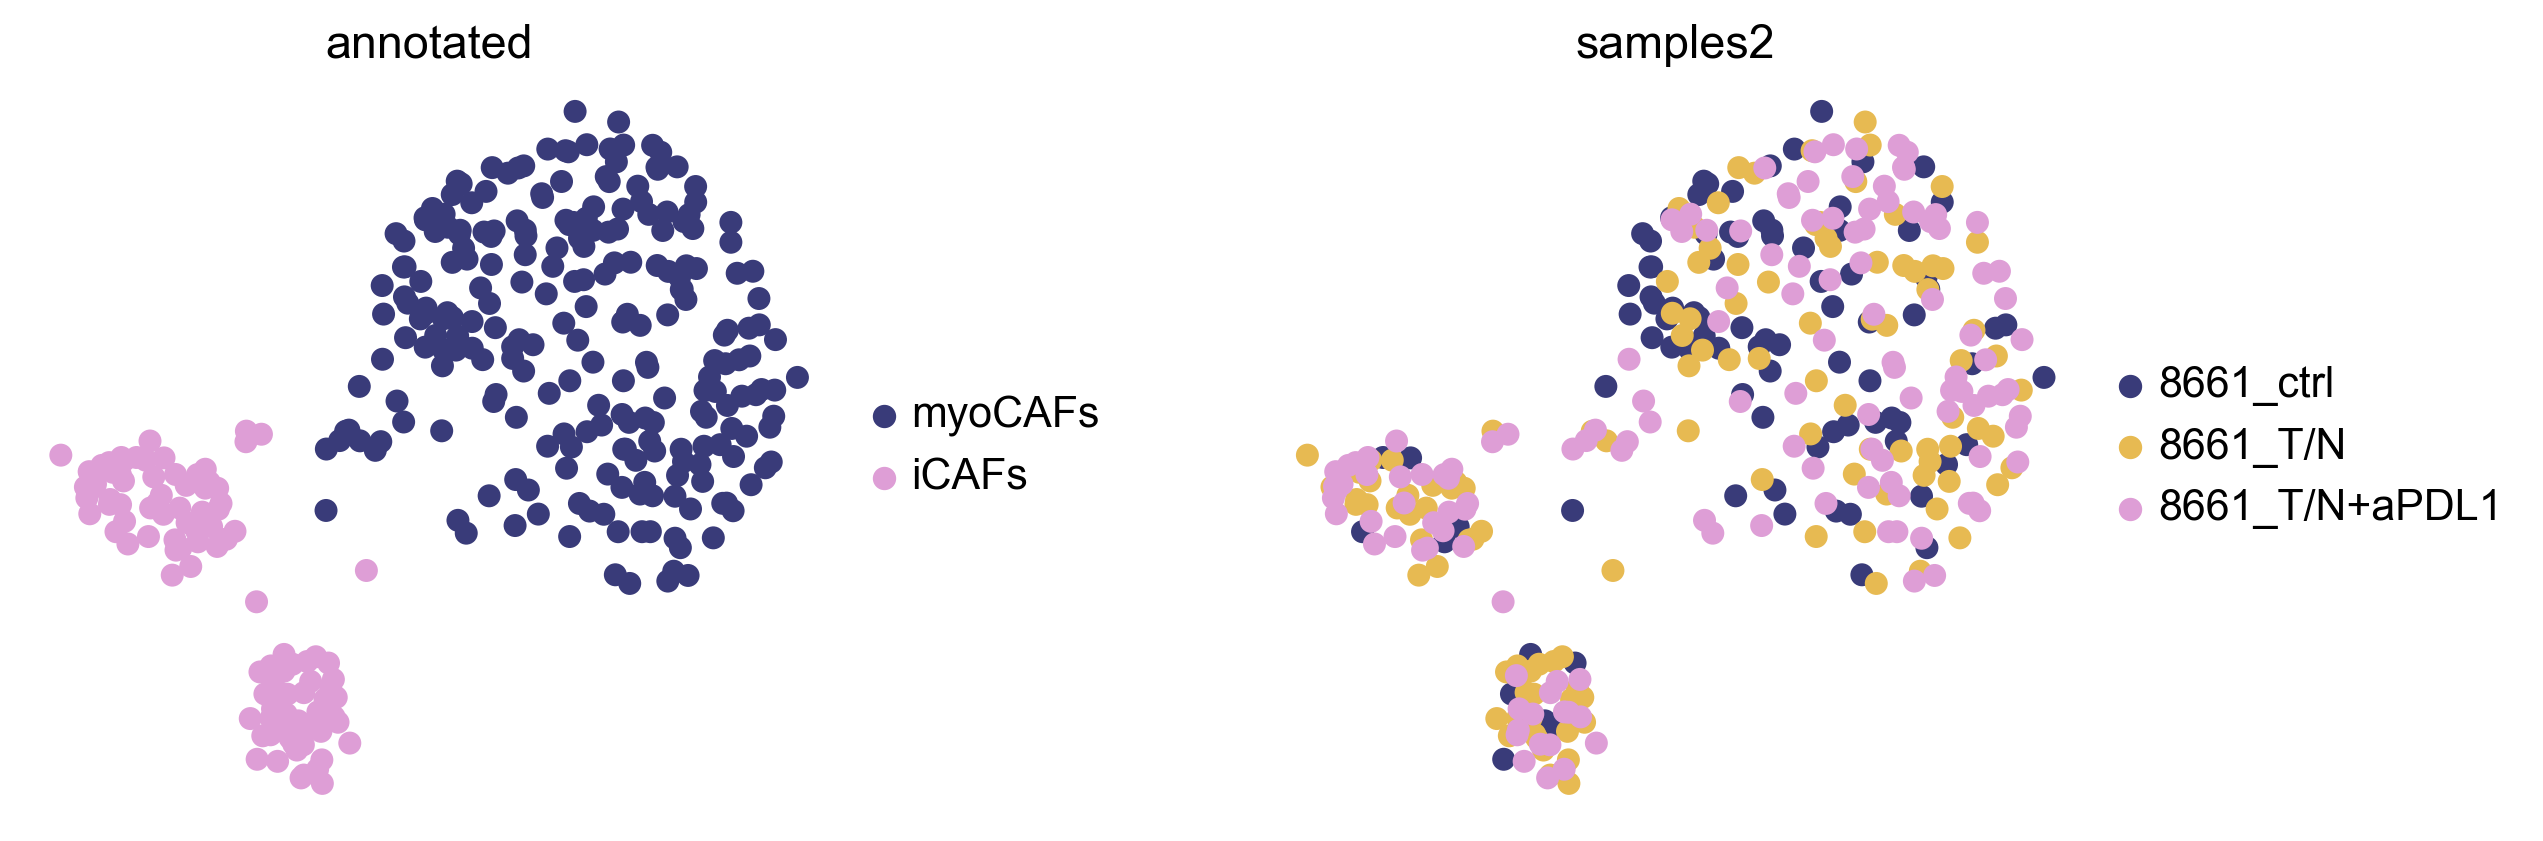

In [29]:
sc.pl.umap(adata, color=['annotated','samples2'], wspace=0.4,frameon=False, palette='tab20b',size=190,save='_annotated')  

### Focused investigation

In [30]:
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

In [31]:
fibro_markers=('Clec3b','Col14a1','Pdgfra','Cxcl12','Dpt','Lmna',
               'Tagln', 'Acta2','Postn','Thy1','Col12a1','Thbs2',
               'H2-Ab1','Saa3','Slpi')

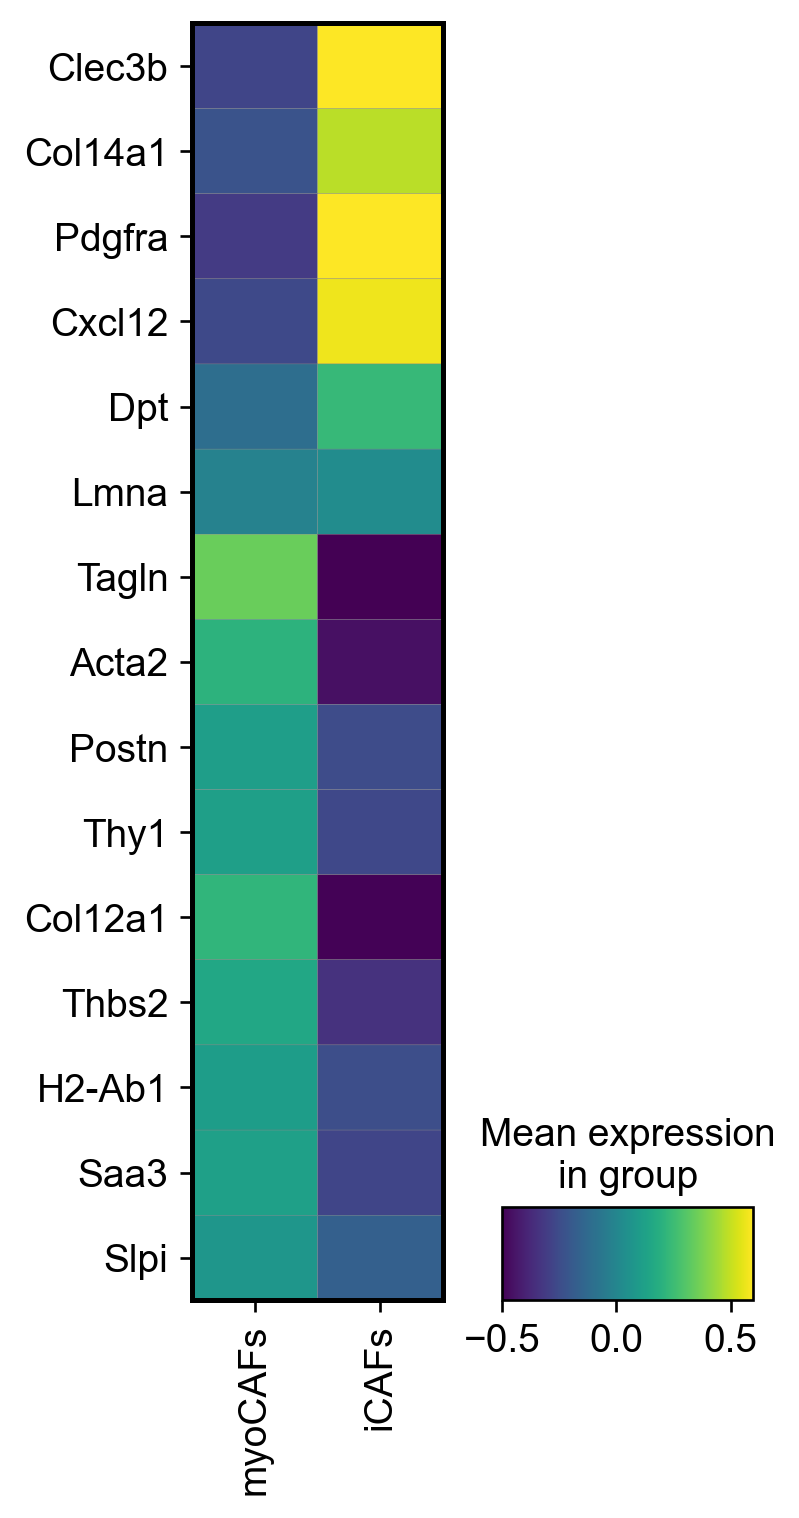

In [35]:
sc.pl.matrixplot(adata, fibro_markers, groupby='annotated', figsize=(3,7),layer='scaled',dendrogram=True, vmin=-0.5, vmax=0.6, swap_axes=True,save='fibro_markers')

In [36]:
adata.obs['annotated'].value_counts()

myoCAFs    238
iCAFs      107
Name: annotated, dtype: int64

In [49]:
FibroVector = pd.DataFrame('myoCAFs',index = adata.obs.index, columns = ['CategoryS'])


for i in range(0, adata.shape[0]):
        if adata.obs['annotated'][i] in ['iCAFs']:
            FibroVector['CategoryS'][i] = 'iCAFs'
        #elif adata.obs['leiden'][i] in ['apCAFs']:
        #   FibroVector['CategoryS'][i] = 'apCAFs'
        else:
            FibroVector['CategoryS'][i] = 'myoCAFs'

adata.obs['CategoryS'] = FibroVector['CategoryS']
adata.obs['CategoryS'] = adata.obs['CategoryS'].astype('category')

In [50]:
use_cells = adata.obs.index[(adata.obs['CategoryS'].isin(['myoCAFs']))]

In [51]:
adata_myoCAFs = adata[use_cells,:].copy()
np.shape(adata_myoCAFs)

(238, 5859)

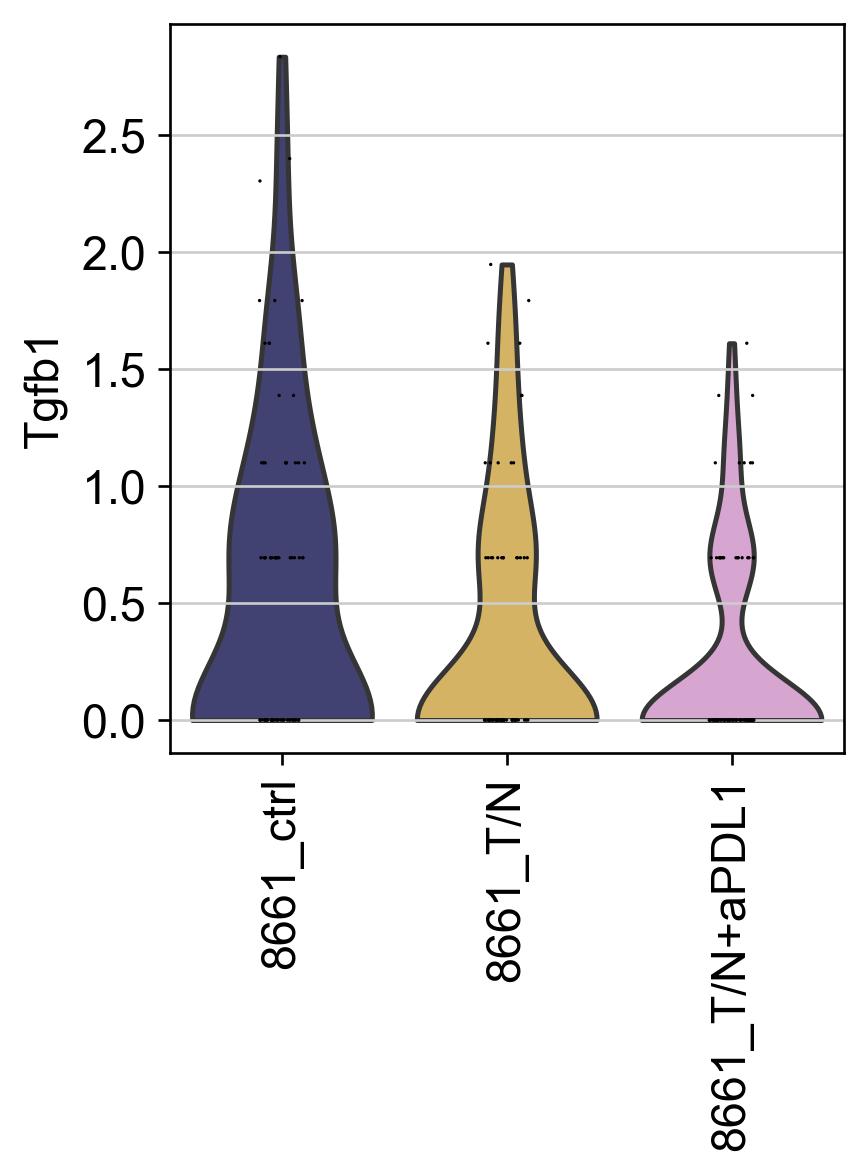

In [53]:
sc.pl.violin(adata_myoCAFs, 'Tgfb1', groupby='samples2',  cmap='tab10', standard_scale='var', rotation=90, save='')

### Quantification of CAF subpopulations

##### Control

In [56]:
adata[(adata.obs['samples2']=='8661_ctrl') 
      & (adata.obs['annotated']=='myoCAFs'),:].shape[0]/adata[(adata.obs['samples2']=='8661_ctrl')].shape[0]

0.8777777777777778

In [57]:
adata[(adata.obs['samples2']=='8661_ctrl') 
      & (adata.obs['annotated']=='iCAFs'),:].shape[0]/adata[(adata.obs['samples2']=='8661_ctrl')].shape[0]

0.12222222222222222

##### T+N

In [58]:
adata[(adata.obs['samples2']=='8661_T/N') 
      & (adata.obs['annotated']=='myoCAFs'),:].shape[0]/adata[(adata.obs['samples2']=='8661_T/N')].shape[0]

0.5897435897435898

In [59]:
adata[(adata.obs['samples2']=='8661_T/N') 
      & (adata.obs['annotated']=='iCAFs'),:].shape[0]/adata[(adata.obs['samples2']=='8661_T/N')].shape[0]

0.41025641025641024

##### T+N+anti PD-L1

In [60]:
adata[(adata.obs['samples2']=='8661_T/N+aPDL1') 
      & (adata.obs['annotated']=='myoCAFs'),:].shape[0]/adata[(adata.obs['samples2']=='8661_T/N+aPDL1')].shape[0]

0.6521739130434783

In [61]:
adata[(adata.obs['samples2']=='8661_T/N+aPDL1') 
      & (adata.obs['annotated']=='iCAFs'),:].shape[0]/adata[(adata.obs['samples2']=='8661_T/N+aPDL1')].shape[0]

0.34782608695652173